# Step 2: make your autoencoder

In [1]:
# import libraries
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split

from nn.nn import NeuralNetwork

## Load MNIST digit dataset and train/val split

In [2]:
mnist = datasets.load_digits()
X_train, X_val, y_train, y_val = train_test_split(mnist.data, mnist.target, test_size=0.2, random_state=42)
print('Training set: (instances, features) ', X_train.shape)
print('Validation set: (instances, features) ', X_val.shape)

Training set: (instances, features)  (1437, 64)
Validation set: (instances, features)  (360, 64)


## Create instance of nn for a 64x16x64 autoencoder

In [ ]:
arch = [
    {'input_dim': 64, 'output_dim': 16, 'activation': 'relu'},
    {'input_dim': 16, 'output_dim': 64, 'activation': 'relu'},
]
auto = NeuralNetwork(arch, lr=0.003, seed=42, batch_size=16, epochs=500, loss_function='mse')

## Train autoencoder & plot loss curve

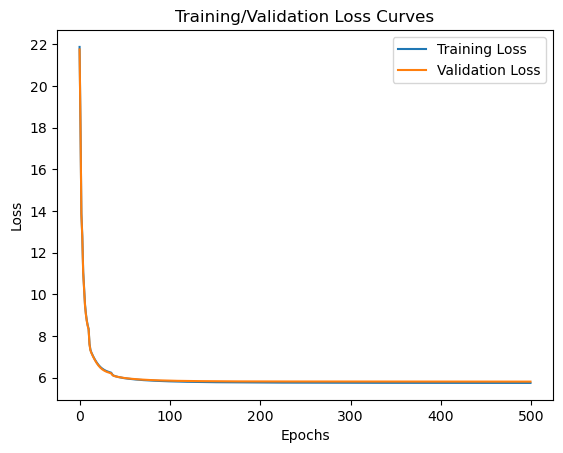

5.8043359711398255


In [4]:
train_loss, val_loss = auto.fit(X_train, X_train, X_val, X_val)

plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training/Validation Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(val_loss[-1]) # average validation loss

In [5]:
recon = (auto.predict(X_val.T)).T
print(f'Avg. Validation Error: {np.mean(np.square(X_val - recon))}')

Avg. Validation Error: 5.804335971139826


## Show image reconstruction for 6 random images

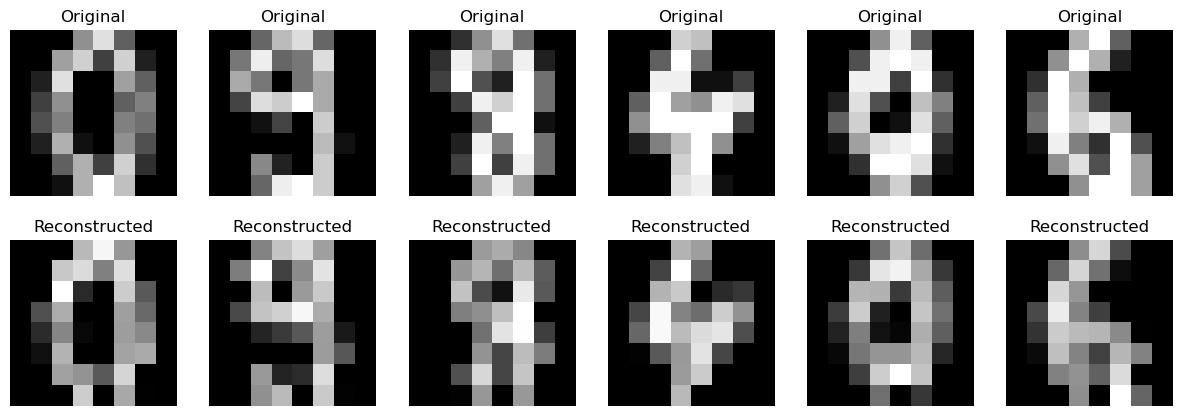

In [14]:
import random
n = 6
plt.figure(figsize=(15, 5))
for i in range(n):
    j = random.randint(0,359)
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_val[j].reshape(8, 8), cmap='gray')
    plt.title('Original')
    plt.axis('off')

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(recon[j].reshape(8, 8), cmap='gray')
    plt.title('Reconstructed')
    plt.axis('off')

## Hyperparameter choice explanation

I played with hyperparameter values to try to maximize performance. Because there is a relatively small number of samples, it made sense to keep the batch size on the lower end, however increasing the batch size did not really seem to change performance. Learning rate seemed to have a greater affect on the performance, with larger learning rates preventing the model from converging. My final choice in 500 epochs was probably more generous than necessary as the loss curves seem to flatten out closer to ~100 epochs. I chose ReLU over sigmoid for my activation function, as this is not a binary classification task. MSE was chosen over BCE as the loss function for similar reasons. 

# Step 3: make your classifier

In [2]:
# import additional libraries
from nn.preprocess import sample_seqs, one_hot_encode_seqs
from nn.io import read_text_file, read_fasta_file

## Load Rap1 files, EDA, and preprocess

In [3]:
pos = read_text_file('data/rap1-lieb-positives.txt')
print('# Rap1+ samples: ' + str(len(pos)))
print('Min Rap1+ length: ' + str(np.min([len(seq) for seq in pos])))
print('Max Rap1+ length: ' + str(np.max([len(seq) for seq in pos])))
print('Avg Rap1+ length: ' + str(np.mean([len(seq) for seq in pos])) + '\n')

neg = read_fasta_file('data/yeast-upstream-1k-negative.fa')
print('# Rap1- samples: ' + str(len(neg)))
print('Min Rap1- length: ' + str(np.min([len(seq) for seq in neg])))
print('Max Rap1- length: ' + str(np.max([len(seq) for seq in neg])))
print('Avg Rap1- length: ' + str(np.mean([len(seq) for seq in neg])))

# Rap1+ samples: 137
Min Rap1+ length: 17
Max Rap1+ length: 17
Avg Rap1+ length: 17.0

# Rap1- samples: 3163
Min Rap1- length: 52
Max Rap1- length: 1000
Avg Rap1- length: 999.1454315523238


Clip Rap- samples to be the same length as Rap+ samples

In [4]:
neg = [seq[:len(pos[0])] for seq in neg]
print('Min Rap1- length: ' + str(np.min([len(seq) for seq in neg])))
print('Max Rap1- length: ' + str(np.max([len(seq) for seq in neg])))

Min Rap1- length: 17
Max Rap1- length: 17


## Balance classes and perform one-hot encoding, and train/val split
In this instance, I am using nn.preprocess.sample_seqs to upsample the Rap1+ sequences. However, in practice, it would probably be a better choice to first downsample the Rap1- sequences a bit before upsampling the Rap+ sequences due to the drastic disparity in class representation (approx 1 Rap1+:23 Rap-)

In [5]:
# combine Rap1+ and Rap1- using df for easier handling and balance using sample_seqs()
all_seq = pd.concat([pd.DataFrame({'sequence': pos, 'label': True}), pd.DataFrame({'sequence': neg, 'label': False})])
X, y = sample_seqs(all_seq['sequence'], all_seq['label'])
# one-hot encoding
X_oneHot = one_hot_encode_seqs(X)

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X_oneHot, np.array(y), test_size=0.2, random_state=42)

## Generate an instance of your NeuralNetwork class with an appropriate architecture

In [7]:
arch = [{"input_dim": 68, "output_dim": 30 , "activation": "relu"},
        {"input_dim": 30, "output_dim": 10, "activation": "relu"},
        {"input_dim": 10, "output_dim": 1, "activation": "sigmoid"}]
classif = NeuralNetwork(arch, lr=0.001, seed=42, batch_size=32, epochs=250, loss_function='bce')

## Train classifier & plot loss curve

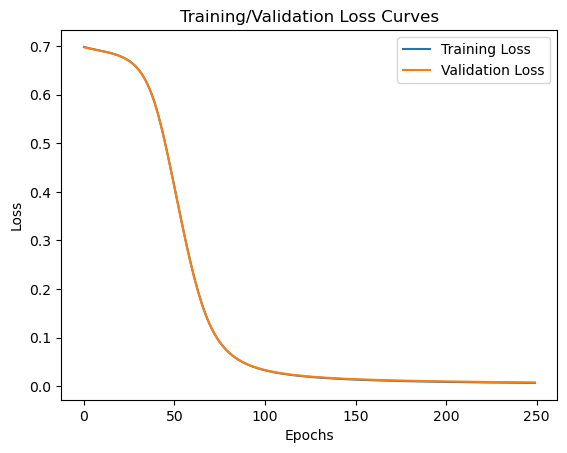

average validation loss: 0.00797674388788302


In [8]:
train_loss, val_loss = classif.fit(X_train, y_train, X_val, y_val)

plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training/Validation Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(f'average validation loss: {val_loss[-1]}') 

## Report Val Accuracy

In [9]:
y_hat = classif.predict(X_val.T).T
accuracy = np.mean((y_hat > 0.5).flatten() == y_val)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9976303317535545


## Hyperparameter Choice Explanation

I tested a few architectures, but ultimately landed on 68x30x10x1 to gradually reduce the dimensionality to 1 for purposes of Rap1+/Rap1- classification. I chose ReLU for the hidden layer activation functions as it provides sparsity, then used sigmoid for the output layer since we are performing binary classification. 

My hyperparameter choices were similar to that for the autoencoder--I chose 32 for batch number as we are working with a relatively small number of samples. A learning rate of 0.001 lead to convergence and a pretty smooth learning curve. Again, 250 epochs was probably overkill as the loss curves flatten around 125 epochs. Finally, I chose BCE over MSE for the loss function as we are performing a binary classification. 